In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Note, if you don't already have Pytorch you will need to install it

See https://pytorch.org/ (or use Google Collab)

# Let's assume our data is generated according to

$$x_{i, k} \sim \text{Poiss}\left(\sum_{d=1}^D z_{i,d}\theta_{d,k}\right) i=1,\dots,N,\; k=1,\dots, K$$

where $D=2, K=16$, and where the true $\theta$ and $x$ are as follows:

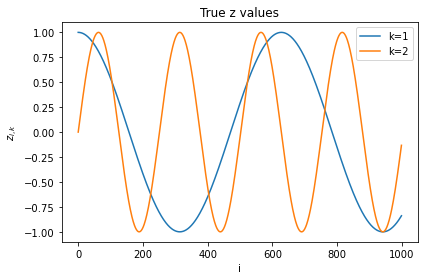

In [11]:
t = np.linspace(0, 10, 1000)
true_z = np.zeros((1000, 2))
true_z[:, 0] = np.cos(t)
true_z[:, 1] = np.sin(t*2.5)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(true_z[:, 0], label='k=1')
ax.plot(true_z[:, 1], label='k=2')
ax.set_xlabel('i')
ax.set_ylabel(r'$z_{i,k}$')
ax.legend()
ax.set_title('True z values')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

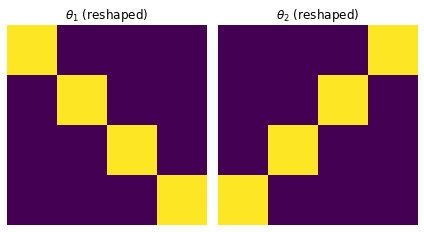

In [6]:
true_theta = 2*np.array([[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1], [0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0]]) + 0.1

fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True)
ax[0].imshow(true_theta[0, :].reshape(4,4))
ax[0].axis('off')
ax[0].set_title(r'$\theta_1$ (reshaped)')
ax[1].imshow(true_theta[1, :].reshape(4,4))
ax[1].axis('off')
ax[1].set_title(r'$\theta_2$ (reshaped)')
plt.show

## Note that $\theta_1, \theta_2$ are vectors, that can be reshaped to give the images above

true rates for 10 time points


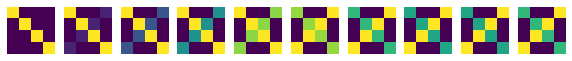

reshaped observations for 10 time points


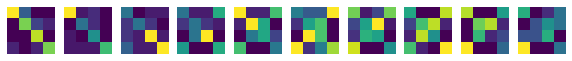

In [7]:
true_rate = np.exp(np.dot(true_z, true_theta))
print('true rates for 10 time points')
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(10):
    ax[i].imshow(true_rate[i*10,:].reshape(4,4))
    ax[i].axis('off')
plt.show()

print('reshaped observations for 10 time points')
x = np.random.poisson(true_rate)
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(10):
    ax[i].imshow(x[i*10,:].reshape(4,4))
    ax[i].axis('off')
plt.show()

# Let's assume the following parametric model $p_\theta(z, x)$

$$\begin{aligned}
z_{i, d} \sim& N(0, 1) & i=1,\dots,N,\; d=1,\dots, D\\
\theta_{k, d} \sim& N(0, 1) & k=1,\dots,K,\; d=1,\dots, D\\
x_{i, k} \sim& \text{Poiss}\left(\exp\left\{\sum_d z_{i,d}\theta_{d,k}\right\}\right)& i=1,\dots,N,\; k=1,\dots, K\\\end{aligned}$$


# We will use an MLP to model our $q_\phi(z|x)$

$$q_\phi(z|x) = N\left(\mu_\phi(x), \sigma^2_\phi(x)\right)$$





We can use the reparametrization trick to sample $z^{(i,\ell)}\sim q_\phi(z|x^{(i)})$:
$$\begin{aligned}
\epsilon^{(\ell)} \sim& N\left(0, \mathbb{I}_D\right)\\
z_i^{(\ell)} =& \mu_\phi(x_i) + \sigma_\phi(x_i)\odot\epsilon^{(\ell)}\end{aligned}$$



Concretely, for the NN, I'm going to use:

$$\begin{aligned}h_i =& ReLU(W^{(1)} x_i + b^{(1)})\\
\log(\sigma_i^2) =& W^{(2)}h_i + b^{(2)}\\
\mu_i =& W^{(3)}h_i + b^{(3)}\end{aligned}$$


# In order to train our model, we need to be able to estimate the ELBO.

Fill out the following form to get an estimator of the ELBO based on $L$ samples $\{z_i^{(\ell)}\}_{\ell=1}^L$ (hint: look at the example of Section 3 in the paper)

$$\begin{aligned}\text{ELBO} =& \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(z, x) - \log q_\phi(z|x)\right]\\
\simeq TODO
\end{aligned}
$$

# We are going to optimize $\theta$. 

We could do this either in an ML or MAP way; I am going to do MAP here by adding a regularization term

# Now, take a look at the following code and fill in the ELBO loss


For those of you who don't know Pytorch:
* The class Poisson_AEVB contains the definition of our NN and what it does 
* The init method sets up the parameters of the NN (ie $\phi$).
    * nn.Linear sets up the parameters for a single layer neural network
    * BatchNorm1d is a normalization transform, if you want more info see https://en.wikipedia.org/wiki/Batch_normalization or one of the many blog posts on the topic
    * We also have to optimize $\theta$. Anything that is a Parameter can be optimized
    * If we initialize $\theta$ too large, we risk numeric errors when we first calculate $e^{z\theta}$, hence the renormalization
    * We don't neeed to include our ReLU nonlinearities here since they don't have parameters
* The forward method implements $q_\phi(z|\theta)$.
    * It samples random noise, which is held fixed during optimization, and returns $\mu$,  $\sigma$ and $\text{\sc{rate}}=\exp(z\theta)$ (we could return other things, provided we have enough info to calculate our loss)

* The term elbo_loss calculates the negative of the ELBO (plus the regularizer for $\theta$)
    * Negative, because we want the ELBO to increase but we are doing gradient descent
    
    
We will then initialize our model, and set up an optimizer that calculates the gradients with respect to each parameter.

For more info, check out the tutorial here: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [8]:
class Poisson_AEVB(nn.Module):

    def __init__(self):
        super(Poisson_AEVB, self).__init__()
        # Setting up the parameters for q_phi
        
        self.fc1 = nn.Linear(16, 8) # fully connected NN, 16-dim input, 8-dim output
        self.fc1_bn=nn.BatchNorm1d(8) # batch norm layer for stability
        self.fc_mu = nn.Linear(8, 2) # fully connected NN, 8-dim input, 2-dim output
        self.fc_sigma = nn.Linear(8, 2) # fully connected NN, 8-dim input, 2-dim output
        
        # parameters to be optimized
        self.theta = torch.randn((2,16))
        # re-scale to avoid blowing up due to the exponent in the forward method
        self.theta/= torch.exp(torch.linalg.norm(torch.tensor(self.theta), axis=0))
        self.theta = torch.nn.Parameter(self.theta) 
        
    def forward(self, x):
        # calculate mu(x), sigma(x); sampling z and calculating rate.
        x = F.relu(self.fc1_bn(self.fc1(x)))
        mu = self.fc_mu(x)
        log_var = self.fc_sigma(x)
        sigma = torch.exp(log_var / 2)
        
        noise = torch.randn_like(sigma)
        z = mu + noise * sigma # just using L=1 for now
        rate = torch.exp(torch.matmul(z, self.theta))
        
        return mu, sigma, rate

    def elbo_loss(self, x, mu, sigma, rate):
        # technically this will be the negative ELBO, since we want our ELBO to increase but we are doing gradient descent
        q_loss = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2, 1) 
    
        p_loss = torch.sum(rate - x*torch.log(rate), 1) # negative log likelihood under q
    
        theta_loss = torch.sum(0.5*self.theta**2) # MAP regularizer for theta
        return torch.sum(p_loss + q_loss) + theta_loss
    


In [9]:
x_torch = torch.Tensor(x)
model = Poisson_AEVB()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    mu, sigma, rate = model(x_torch)
    
    loss = model.elbo_loss(x_torch, mu, sigma, rate)
    if torch.isnan(loss): # break out if we end up with numerical instabilities
        print('Oh no!! Numeric instabilities. Try again')
    loss.backward()
    optimizer.step()
    if epoch%1000== 0:
        print('approx elbo: -{}'.format(loss.item()))

/var/folders/2s/3mnfvpbd2f9bdrm1t5h7zs8c0000gn/T/ipykernel_96642/2005394369.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta/= torch.exp(torch.linalg.norm(torch.tensor(self.theta), axis=0))


approx elbo: 17858.87890625
approx elbo: 1093.613037109375
approx elbo: 422.69390869140625
approx elbo: 274.2865905761719
approx elbo: 183.52867126464844
approx elbo: 181.94834899902344
approx elbo: 110.0666732788086
approx elbo: 137.45567321777344
approx elbo: 220.29090881347656
approx elbo: 146.308837890625


# Check that the mean of $q(z|x)$ matches our ground truth

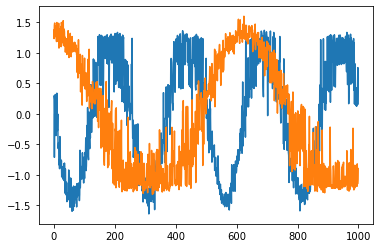

In [12]:
plt.plot(mu.detach().numpy())
plt.show()

# Take a look at whether our estimated $\theta$ looks like the ground truth

<function matplotlib.pyplot.show(close=None, block=None)>

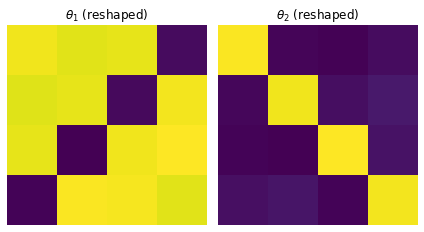

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True)
ax[0].imshow(model.theta[0, :].detach().numpy().reshape(4,4))
ax[0].axis('off')
ax[0].set_title(r'$\theta_1$ (reshaped)')
ax[1].imshow(model.theta[1, :].detach().numpy().reshape(4,4))
ax[1].axis('off')
ax[1].set_title(r'$\theta_2$ (reshaped)')
plt.show


# The estimated z's and $\theta$'s should look pretty close to what we had (note, we might have a sign flip for both z and the corresponding $\theta$)

They don't??? Go back and check your loss code! (Maybe you forgot to use the negative ELBO?)